In [1]:
from geoband.API import *
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import fiona
import folium
import webbrowser

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 데이터 셋팅

In [2]:
data = gpd.read_file('./final_result.geojson')
grid = gpd.read_file('./grid.geojson')
# shape = gpd.read_file('./grid.shp') 직접 만든 격자데이터
zinb_all = pd.read_csv('./zinb_all_prediction.csv') # 판다스 객체

In [3]:
# gid, 예측값만 가져와 상위 100개 

top100 = zinb_all[['gid', 'new.d$prediction']].sort_values('new.d$prediction', ascending=False).head(100)

In [4]:
# 기존 데이터와 병합

top100_info = pd.merge(data, top100, on='gid', how='inner') # geo판다스 객체
top100_info.rename(columns={'new.d$prediction':'prediction'}, inplace=True) # 예측값 칼럼명 변경

In [6]:
top100_info.to_file('./top100.geojson', driver='GeoJSON')
top100_info.to_csv('./top100.csv')

# 시각화

In [7]:
import geoplot as gplt #conda install -c conda-forge geoplot
import geoplot.crs as gcrs
import mapclassify as mc

In [7]:
top100_info['geometry'] = top100_info['geometry'].centroid  # 격자의 중심점

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [8]:
top100_info.to_csv('./top100_centroid.csv')

# 1. 그냥 점으로 찍기

<AxesSubplot:>

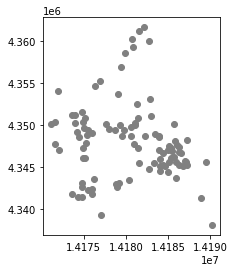

In [10]:
top100_info2 = top100_info.to_crs(epsg=3857)  #좌표계를 epsg 3857로 변환
top100_info2.plot(color='gray')

# 2. 행정지도

## 2.1. shp

http://www.gisdeveloper.co.kr/?p=2332

In [11]:
shi = gpd.read_file('./shape_file/시도.shp', encoding='euc-kr') # 대전광역시
gu = gpd.read_file('./shape_file/시군구.shp', encoding='euc-kr') # 유성구 대덕구 서구 중구 동구

In [12]:
# 좌표계 세팅

shi.crs = "epsg:5179"
shi2 = shi.to_crs(epsg=3857)

gu.crs = "epsg:5179"
gu2 = gu.to_crs(epsg=3857)

### 2.1.1. 대전시 내 행정구역

In [13]:
# 대전시 행정구역 : 유성구 대덕구 서구 중구 동구

gu2['DO'] = gu2['SIG_CD'].str.slice(start=0, stop=2) 
gu3 = gu2[gu2['DO'].str.contains('30')==True]  
gu3.info()
gu3.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5 entries, 119 to 123
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SIG_CD      5 non-null      object  
 1   SIG_ENG_NM  5 non-null      object  
 2   SIG_KOR_NM  5 non-null      object  
 3   geometry    5 non-null      geometry
 4   DO          5 non-null      object  
dtypes: geometry(1), object(4)
memory usage: 240.0+ bytes


,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry,DO
119,30110,Dong-gu,동구,"POLYGON ((14192392.329 4361247.847, 14192291.0...",30
120,30140,Jung-gu,중구,"POLYGON ((14188207.620 4342203.080, 14188207.6...",30
121,30170,Seo-gu,서구,"POLYGON ((14178778.854 4340485.005, 14178778.8...",30
122,30200,Yuseong-gu,유성구,"POLYGON ((14176954.951 4346422.037, 14176926.4...",30
123,30230,Daedeok-gu,대덕구,"POLYGON ((14191163.710 4366467.268, 14191457.3...",30


<AxesSubplot:>

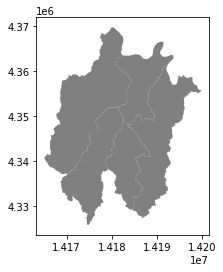

In [14]:
gu3.plot(color='grey')

In [15]:
YS = gu3[gu3['SIG_KOR_NM'].str.contains('유성구')==True]  # 유성구
DD = gu3[gu3['SIG_KOR_NM'].str.contains('대덕구')==True]  # 대덕구
S = gu3[gu3['SIG_KOR_NM'].str.contains('서구')==True]  # 서구
J = gu3[gu3['SIG_KOR_NM'].str.contains('중구')==True]  # 중구
D = gu3[gu3['SIG_KOR_NM'].str.contains('동구')==True]  # 동구

<AxesSubplot:>

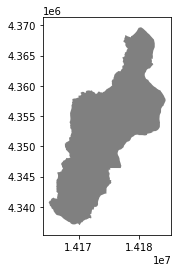

In [16]:
# 유성구
YS.plot(color='grey')

### 2.1.2. 대전광역시

In [17]:
# 대전광역시

shi3 = shi2[shi2['CTP_KOR_NM']=='대전광역시']  
shi3.info()
shi3.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1 entries, 6 to 6
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CTPRVN_CD   1 non-null      object  
 1   CTP_ENG_NM  1 non-null      object  
 2   CTP_KOR_NM  1 non-null      object  
 3   geometry    1 non-null      geometry
dtypes: geometry(1), object(3)
memory usage: 40.0+ bytes


,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry
6,30,Daejeon,대전광역시,"POLYGON ((14181983.201 4368131.812, 14182121.2..."


<AxesSubplot:>

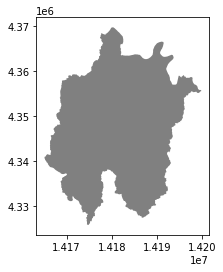

In [18]:
shi3.plot(color='grey')

## 3. 버블맵

In [21]:
gu4326 = gu3.to_crs(epsg=4326)
shi4326 = shi3.to_crs(epsg=4326)

<GeoAxesSubplot:>

/opt/app-root/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


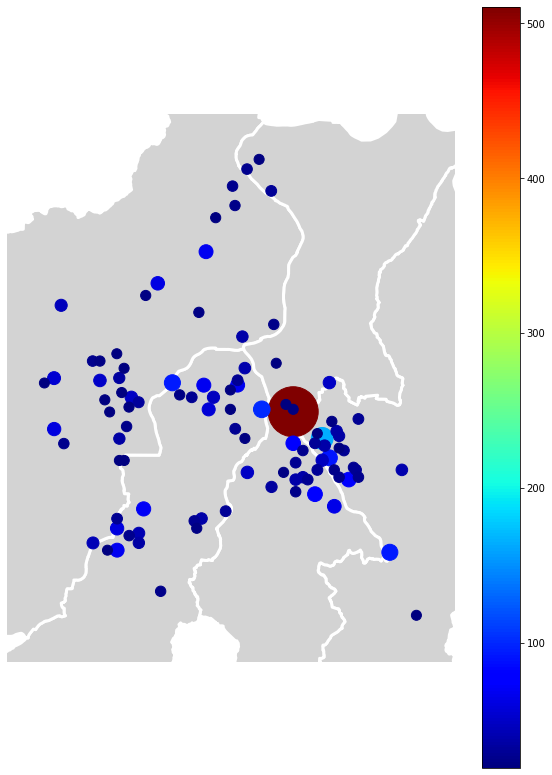

In [22]:
proj = gcrs.WebMercator()

ax = gplt.polyplot(gu4326, zorder=-1, linewidth=3, projection=proj, edgecolor='white',
    facecolor='lightgray', figsize=(10, 14) )

gplt.pointplot(
    top100_info, projection=gcrs.WebMercator(),
    scale='prediction', limits=(10, 50), hue='prediction', cmap='jet',
    legend=True, legend_var='hue',
    ax=ax
)


/opt/app-root/lib/python3.6/site-packages/geoplot/geoplot.py:612: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  extent = gpd.GeoSeries(self.extent) if self.extent is not None else None


<GeoAxesSubplot:>

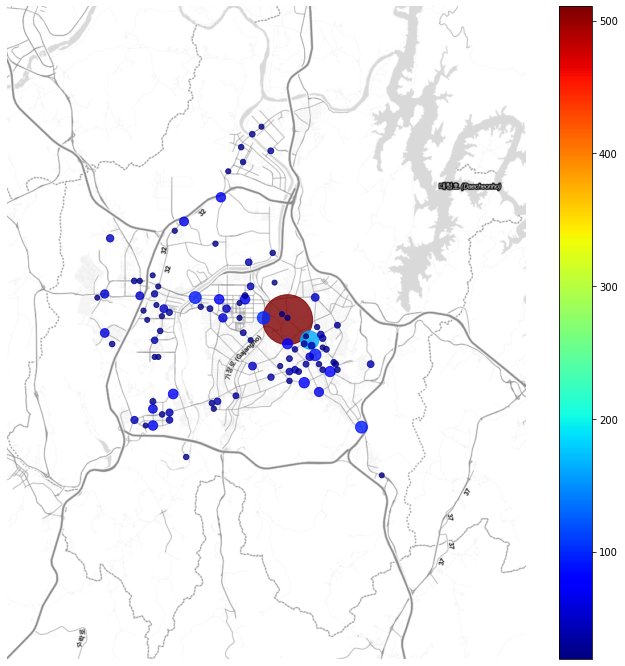

In [23]:
extent = gu4326.total_bounds

ax = gplt.pointplot(top100_info, projection=gcrs.WebMercator(), alpha=0.8,
    scale='prediction', limits=(5, 50), hue='prediction', cmap='jet', 
    legend=True, legend_var='hue', figsize=(12, 12))

gplt.webmap(gu4326, ax=ax, extent=extent, provider='ST_TONER_LITE')

/opt/app-root/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/app-root/lib/python3.6/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/opt/app-root/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarnin

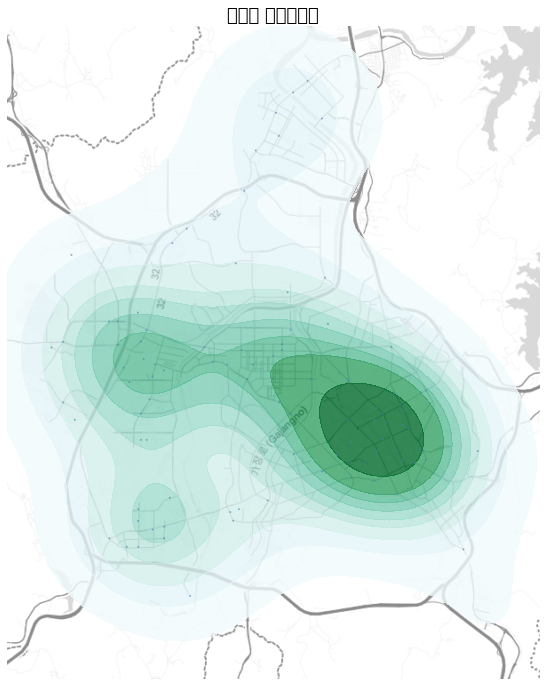

In [25]:
ax = gplt.kdeplot(top100_info, cmap='BuGn', projection=gcrs.WebMercator(), 
                  figsize=(12, 12), shade=True, alpha=0.8)

gplt.pointplot(top100_info, s=1,  alpha=0.5, ax=ax)

gplt.webmap(top100_info, ax=ax, provider='ST_TONER_LITE')

fig = plt.gcf()

# plt.savefig("CCTV_Heatmap.png") #, bbox_inches='tight', pad_inches=0.01)

## 실폭도로 
http://data.nsdi.go.kr/dataset/20180918ds00072

In [26]:
gdf_road = gpd.read_file('./shape_file/실폭도로.shp', encoding='euc-kr') # 대전광역시

<AxesSubplot:>

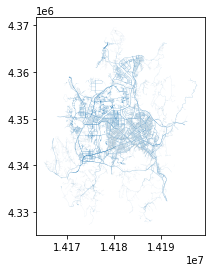

In [30]:
gdf_road.crs = "epsg:5181"
gdf_road3857 = gdf_road.to_crs(epsg=3857)
gdf_road3857.plot()

In [32]:
gdf_road['SIG_CD'].unique() # 구별로 도로 나눠져 있는 듯!

array(['30110', '30140', '30170', '30200', '30230'], dtype=object)

<AxesSubplot:>

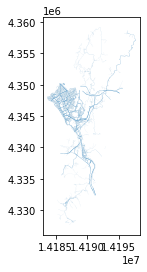

In [33]:
gdf_road3857_D = gdf_road3857[gdf_road3857['SIG_CD']=='30110']
gdf_road3857_D.plot()

In [45]:
top100_info

,gid,sg_walk_cnt,sg_car_cnt,safe_zn_cnt,cro_cnt,spd_sign_cnt,spd_diff,spd_sign,pull_over_cnt,cctv_cnt,...,kid_pro,building_kid_cnt,building_old_cnt,acci_cnt,acci_car_cnt,acci_pm_cnt,acci_kid_cnt,acci_old_cnt,geometry,prediction
0,다바856116,3.0,8.0,4.0,3.0,6.0,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,15,14.0,0.0,0.0,0.0,POINT (127.34017 36.30207),25.460539
1,다바950143,8.0,10.0,1.0,7.0,6.0,20.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,28,23.0,0.0,2.0,2.0,POINT (127.44485 36.32650),29.753730
2,다바936156,8.0,12.0,6.0,10.0,6.0,20.0,1.0,0.0,2.0,...,0.000000,0.0,0.0,17,16.0,0.0,0.0,1.0,POINT (127.42924 36.33822),164.382668
3,다바941128,8.0,13.0,1.0,6.0,3.0,20.0,1.0,0.0,2.0,...,14.754098,0.0,0.0,50,42.0,1.0,2.0,3.0,POINT (127.43483 36.31298),64.567046
4,다바934143,4.0,8.0,0.0,2.0,8.0,20.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,16,16.0,0.0,0.0,0.0,POINT (127.42702 36.32650),29.487483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,다바916203,5.0,8.0,3.0,5.0,2.0,0.0,1.0,0.0,2.0,...,0.000000,0.0,0.0,9,9.0,0.0,0.0,0.0,POINT (127.40690 36.38057),24.385622
96,다바851123,4.0,5.0,4.0,5.0,9.0,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,POINT (127.33459 36.30837),28.628905
97,다바874179,0.0,11.0,5.0,0.0,5.0,0.0,1.0,0.0,2.0,...,0.000000,0.0,0.0,32,32.0,0.0,0.0,0.0,POINT (127.36012 36.35889),93.638097
98,다바884119,2.0,11.0,6.0,4.0,2.0,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,3,3.0,0.0,0.0,0.0,POINT (127.37135 36.30481),22.064847
